In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from skcriteria import Data, MIN, MAX
from skcriteria.madm import closeness, simple

## Bring in data

In [13]:
health_path = "american_lung_county_health_data.csv"
fire_path = "MT_counties_extreme_fire_danger_shp"
res_path = '../shapefiles/MontanaReservations_shp/MontanReservations_4326.shp'
res_bounds = gpd.read_file(res_path)
df_health = pd.read_csv(health_path, skiprows=1)
df_health['County'] = df_health['County'].str.upper()
df_health = df_health[df_health['County'] != 'TOTAL:']
df_health['County'][df_health['County'] == 'LEWIS AND CLARK'] = 'LEWIS & CLARK'
df_health_norm = df_health.loc[:, df_health.columns != 'County'].div(df_health['Total Pop'], axis=0)  # normalize data by total population
df_health_norm['County'] = df_health['County']
df_fire = gpd.read_file(fire_path, geometry='geometry')
gdf = pd.merge(df_fire, df_health_norm, how='outer', left_on='NAME', right_on='County')
gdf = gdf.set_index('NAME')
gdf.drop(columns=['County'], inplace=True)
gdf.head()

,fm100_3p_m,fm100_3p_1,fm100_3p_2,geometry,Total Pop,Under 18,65 & Over,Pediatric Asthma,Adult Asthma,COPD,Lung Cancer,CV Disease,Diabetes,Poverty Estimate
NAME,,,,,,,,,,,,,,
CARBON,18.977833,8.485005,10.492827,"POLYGON ((-108.78200 45.63562, -108.78199 45.6...",1.0,0.179506,0.248411,0.015333,0.073111,0.058901,0.000467,0.075449,0.075729,0.093399
POWDER RIVER,17.838135,8.107280,9.730855,"POLYGON ((-104.98194 45.78525, -104.98196 45.7...",1.0,0.167808,0.254566,0.014269,0.073630,0.059932,0.000000,0.077055,0.077055,0.119292
MADISON,17.691097,8.728092,8.963005,"POLYGON ((-112.02049 45.85881, -112.02025 45.8...",1.0,0.157554,0.290153,0.013456,0.074862,0.062630,0.000489,0.082324,0.080612,0.098471
BEAVERHEAD,17.206333,8.556302,8.650031,"POLYGON ((-113.50387 45.94147, -113.50327 45.9...",1.0,0.176807,0.215179,0.015158,0.074730,0.053000,0.000424,0.065826,0.066250,0.131227
BIG HORN,19.279182,8.560492,10.718690,"POLYGON ((-107.42493 46.03976, -107.42494 46.0...",1.0,0.342590,0.123802,0.029341,0.060105,0.038772,0.000449,0.045060,0.048054,0.264596


## Randomly weighted MCA

In [24]:
cols = ['fm100_3p_m', 'Under 18', '65 & Over', 'Pediatric Asthma', 'Adult Asthma',
    'COPD', 'Lung Cancer', 'CV Disease', 'Diabetes', 'Poverty Estimate']
data = gdf[cols]
crit = [MIN, MIN, MIN, MIN, MIN, MIN, MIN, MIN, MIN, MIN]
counties = data.index
cnms = data.columns
mtx = data.values

n = 10000
res = np.zeros([len(data), n])
for i in range(n):
    rand_wts = np.random.dirichlet(np.ones(9), size=1)*.54
    wts = list(np.insert(rand_wts, 0, [0.46]))
    mca_data = Data(mtx, crit, anames=counties, cnames=cnms, weights=wts)
    dm = closeness.TOPSIS()
    dec = dm.decide(mca_data)
    # res[:, i] = dec.rank_
    res[:, i] = dec.e_.closeness
# res_df = pd.DataFrame({
#         "name": gdf['NAME'], 
#         "min_rank": res.min(axis=1),
#         "max_rank": res.max(axis=1),
#         "median_rank": np.median(res, axis=1).round(0)
#         })
res_df = pd.DataFrame(res)
res_df.index = gdf.index
res_df = res_df.T

## Plot

[Text(0, 0.5, 'County'), Text(0.5, 0, 'Closeness')]

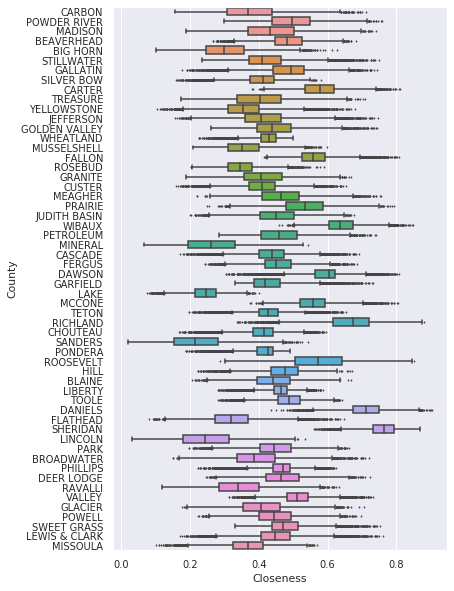

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
res_melt = pd.melt(res_df)
plt.figure(figsize=(6,10))
sns.set(font_scale=.9)
ax = sns.boxplot(data=res_melt, x='value', y='NAME', fliersize=1)
ax.set(ylabel='County', xlabel='Closeness')

In [28]:
fig = ax.get_figure()
fig.savefig("fire_smoke_vulnerability_uncertainty_closeness.png", bbox_inches="tight", dpi=300)